# Tutorial: Fine scale spatial clustering on ultra large-scale Visium HD dataset

Here we present our re-analysis of Human Colorectal Cancer Visium HD dataset. The dataset can be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-crc).\
We have also created a h5ad data for loading convenience, which can be downloaded from the [Google Drive](https://drive.google.com/file/d/1ruuRJEzn5Bf14hlBJMCSj9orCv52IrFV/view?usp=drive_link).

## Preparation

### import library

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import gzip
from scipy.io import mmread
import HERGAST
plt.rcParams["figure.figsize"] = (15, 10)

### read data

In [4]:
data_path = 'data' #replace to your own path
adata = sc.read_h5ad(f'{data_path}/VisiumHD_HumanCRC_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 545913 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### Preprocess

In [5]:
###preprocess
adata.raw = adata.copy()
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True)
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=200)

## Constructing relational graph

In [6]:
HERGAST.utils.Cal_Spatial_Net(adata, k_cutoff=8)
HERGAST.utils.Cal_Expression_Net(adata, dim_reduce='PCA',k_cutoff=6)

------Calculating spatial graph...
Spatial graph contains 4367304 edges, 545913 cells.
8.0000 neighbors per cell on average.
------Calculating Expression simalarity graph...
Expression graph contains 3623953 edges, 545913 cells.
6.6383 neighbors per cell on average.


## Running HERGAST

In [7]:
train_HERGAST = HERGAST.Train_HERGAST(adata, batch_data=True, num_batch_x_y=(7,7), spatial_net_arg={'k_cutoff':8,'verbose':False},
                                      exp_net_arg={'k_cutoff':6,'verbose':False},dim_reduction='PCA',device_idx=0)

Size of Input:  torch.Size([545913, 200])


In [8]:
train_HERGAST.train_HERGAST(n_epochs=200)

100%|██████████| 200/200 [34:32<00:00, 10.36s/it]


## Spatial Clustering

In [9]:
sc.pp.neighbors(adata, use_rep='HERGAST')
sc.tl.umap(adata)
sc.tl.leiden(adata, random_state=2024, resolution=0.3)

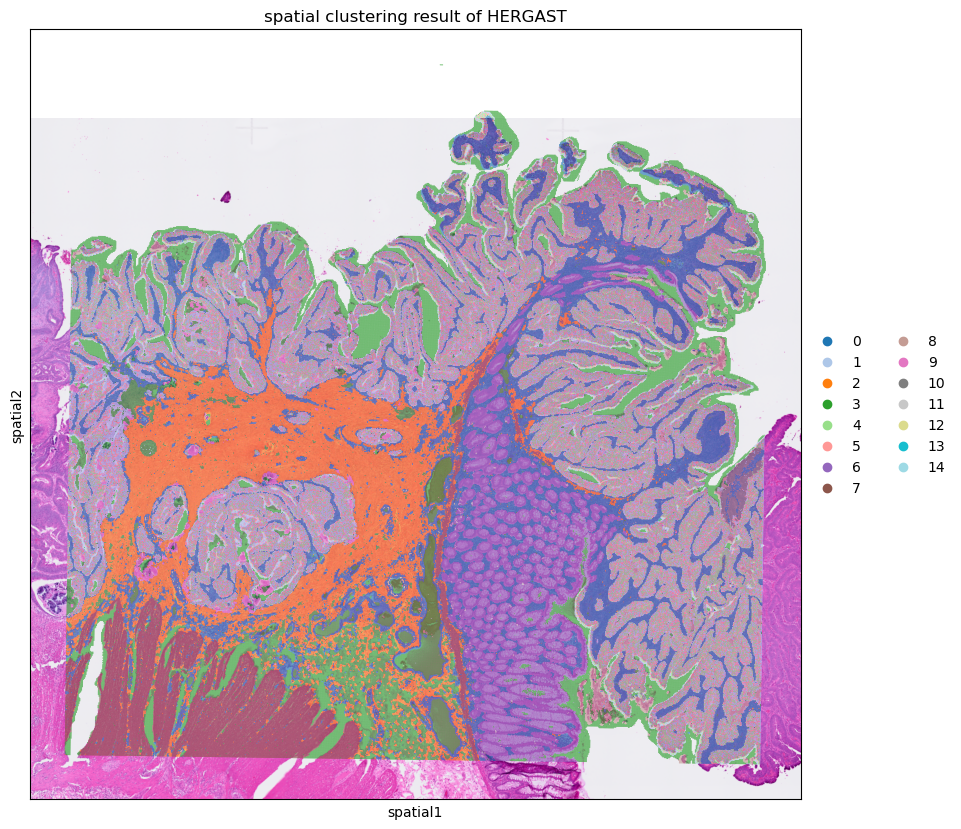

In [12]:
sc.pl.spatial(adata, color='leiden',title='spatial clustering result of HERGAST', palette='tab20')